In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np 
import pickle #to serlialize objects for permenantt storage
import tensorflow as tf
import seaborn as sb

from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline
RANDOM_SEED = 42

In [2]:
sb.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

In [3]:
user_data = pd.read_csv("BOOK2.csv", low_memory=False)
user_data.head()

,user,activity,timestamp,x_axis,y_axis,z_axis,Unnamed: 6
0,33,Jogging,4.910000e+13,5.012288,11.264028,0.953424,NaN
1,33,Jogging,4.910000e+13,4.903325,10.882658,-0.081722,NaN
2,33,Jogging,4.910000e+13,-0.612916,18.496431,3.023717,NaN
3,33,Jogging,4.910000e+13,-1.184970,12.108489,7.205164,NaN
4,33,Jogging,4.910000e+13,1.375655,-2.492524,-6.510526,NaN


In [4]:
user_data["activity"].value_counts()

Walking       111638
Jogging       104582
Upstairs       28898
Downstairs     28600
Sitting         4599
Standing        3555
Name: activity, dtype: int64

array([[<AxesSubplot: title={'center': 'user'}>,
        <AxesSubplot: title={'center': 'timestamp'}>],
       [<AxesSubplot: title={'center': 'x_axis'}>,
        <AxesSubplot: title={'center': 'y_axis'}>],
       [<AxesSubplot: title={'center': 'z_axis'}>,
        <AxesSubplot: title={'center': 'Unnamed: 6'}>]], dtype=object)

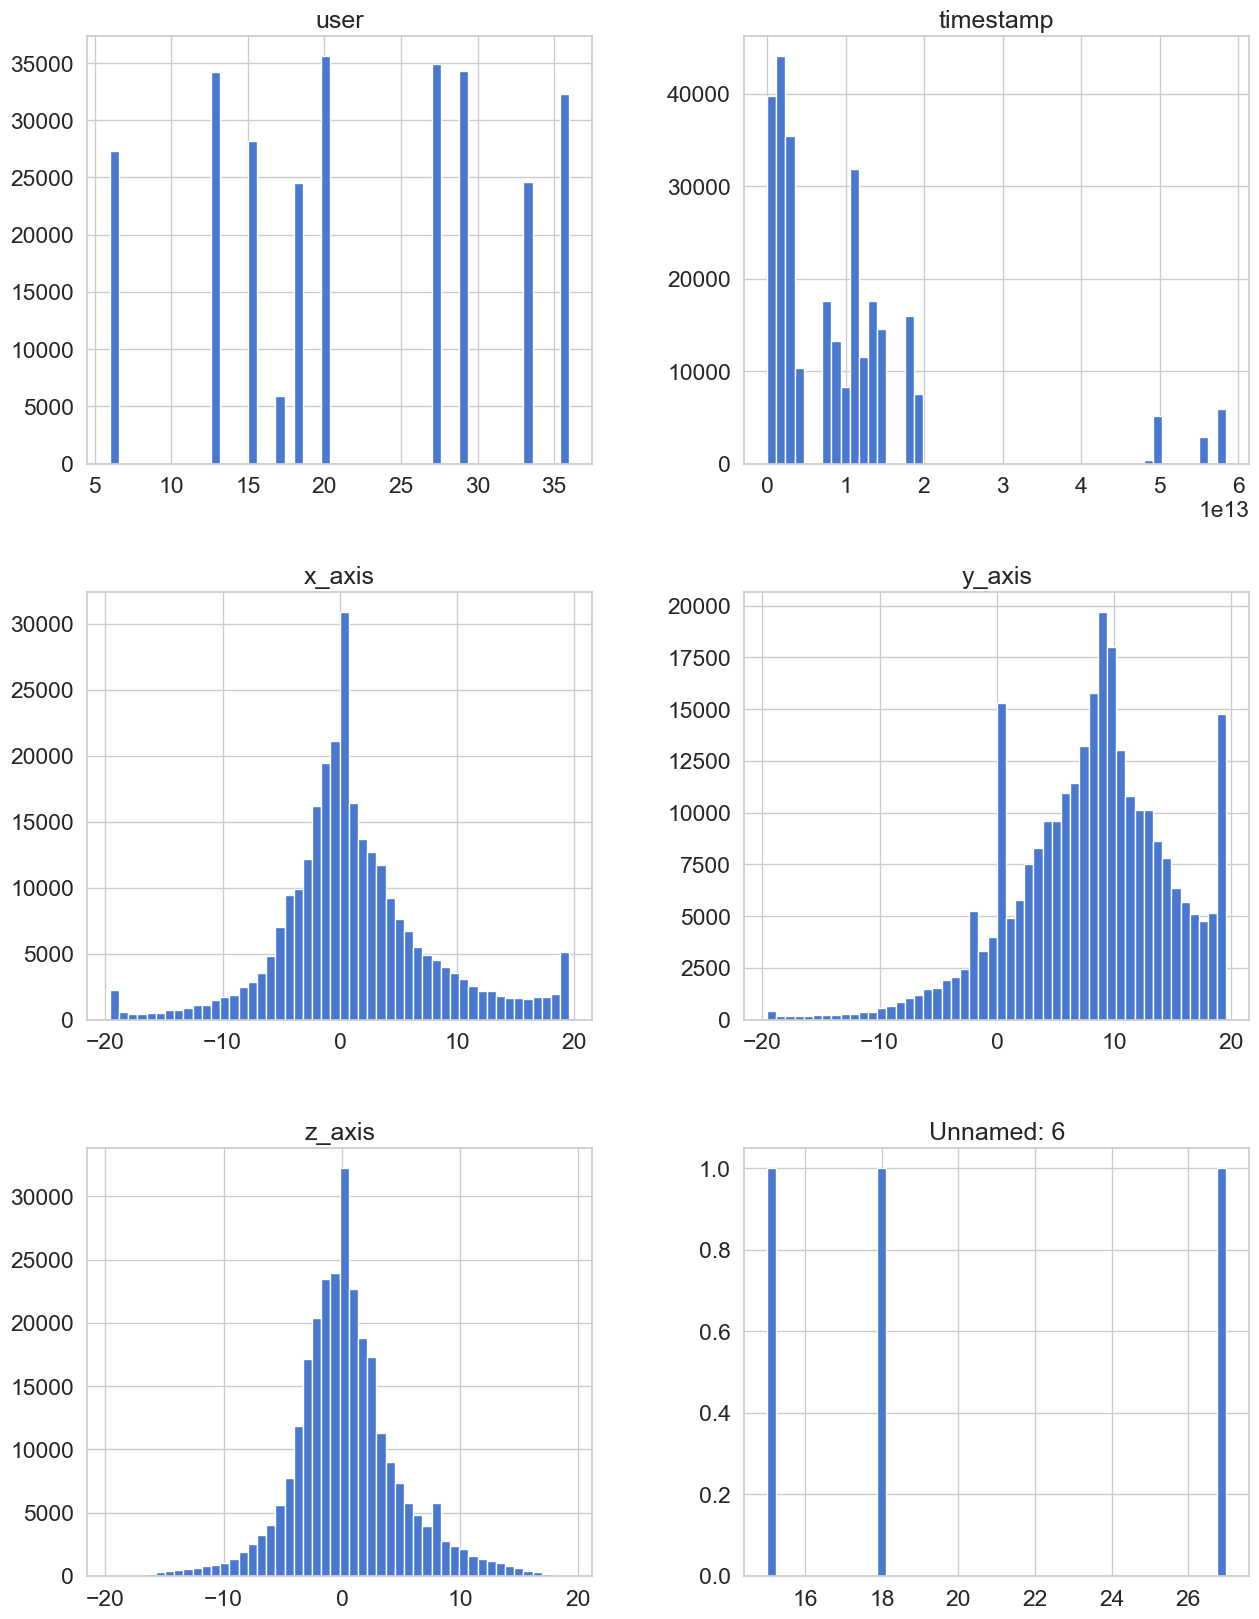

In [5]:
user_data.hist(bins=50, figsize=(15,20))

In [6]:
# from pandas.plotting import scatter_matrix
# attributes= ['user', 'activity',]
# scatter_matrix(user_data[attributes], figsize=(15,20))

<AxesSubplot: title={'center': 'Training Example by Activity'}>

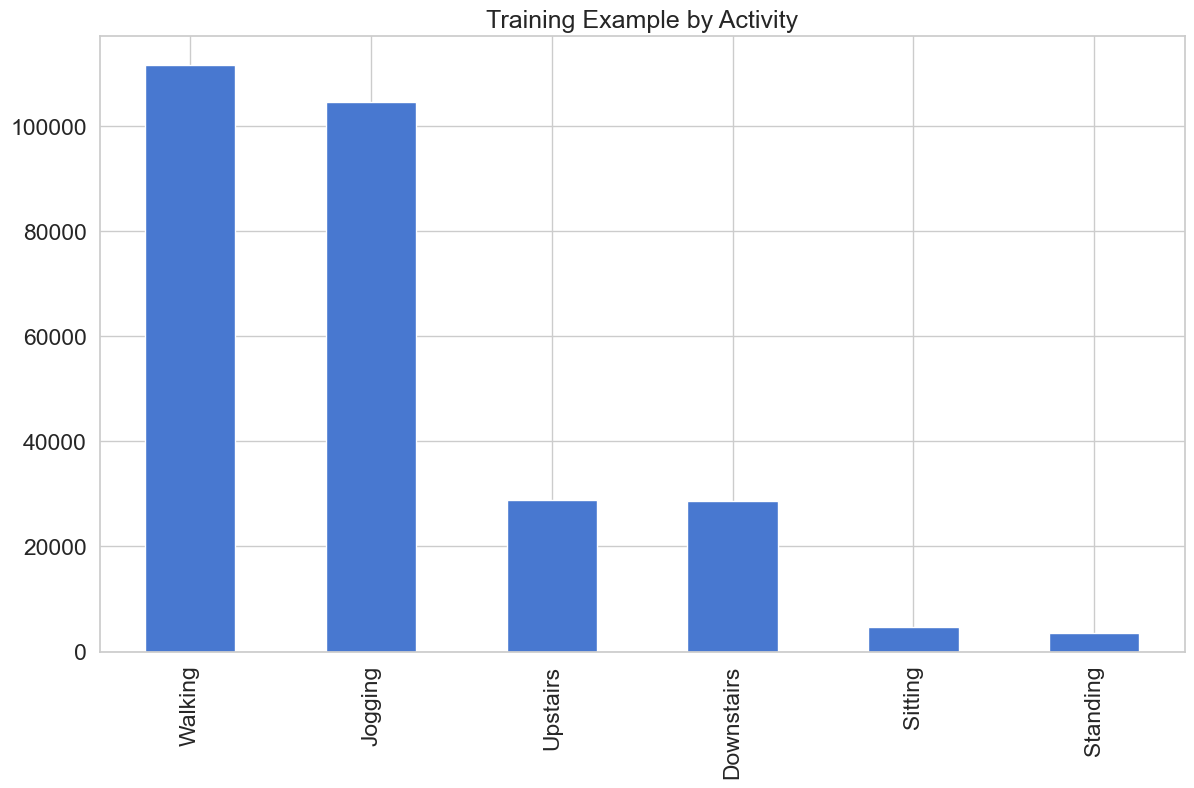

In [7]:
counts = user_data["activity"].value_counts()
counts.plot( kind = 'bar', title= "Training Example by Activity" , figsize = (14,8))

In [8]:
activity_per_person = user_data['user'].value_counts()
activity_per_person

20    35599
27    34958
29    34323
13    34255
36    32261
15    28154
6     27316
33    24592
18    24550
17     5864
Name: user, dtype: int64

In [9]:
total_activity = activity_per_person.sum()
print("Total Actiities : " + str(total_activity))

Total Actiities : 281872


<AxesSubplot: title={'center': 'Training Example by Activity'}>

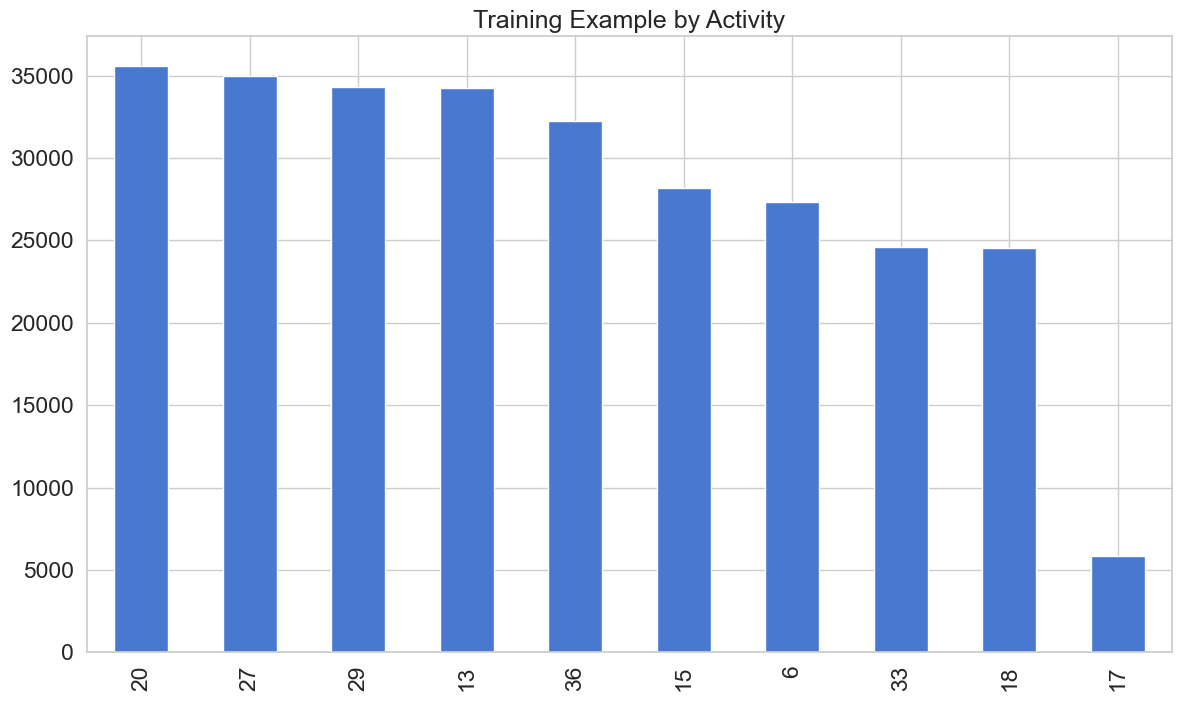

In [10]:
activity_per_person.plot( kind = 'bar', title= "Training Example by Activity" , figsize = (14,8))

## Accelerometer Data representation

In [11]:
def plot_activity (activity, data_frame):
    extractRowsOfActivity = (data_frame['activity'] == activity)
    data = data_frame[extractRowsOfActivity]
    data = data[['x_axis','y_axis', 'z_axis']]
    data = data[:200]
    ax = data.plot(subplots= True , figsize = (16,12), title = activity )

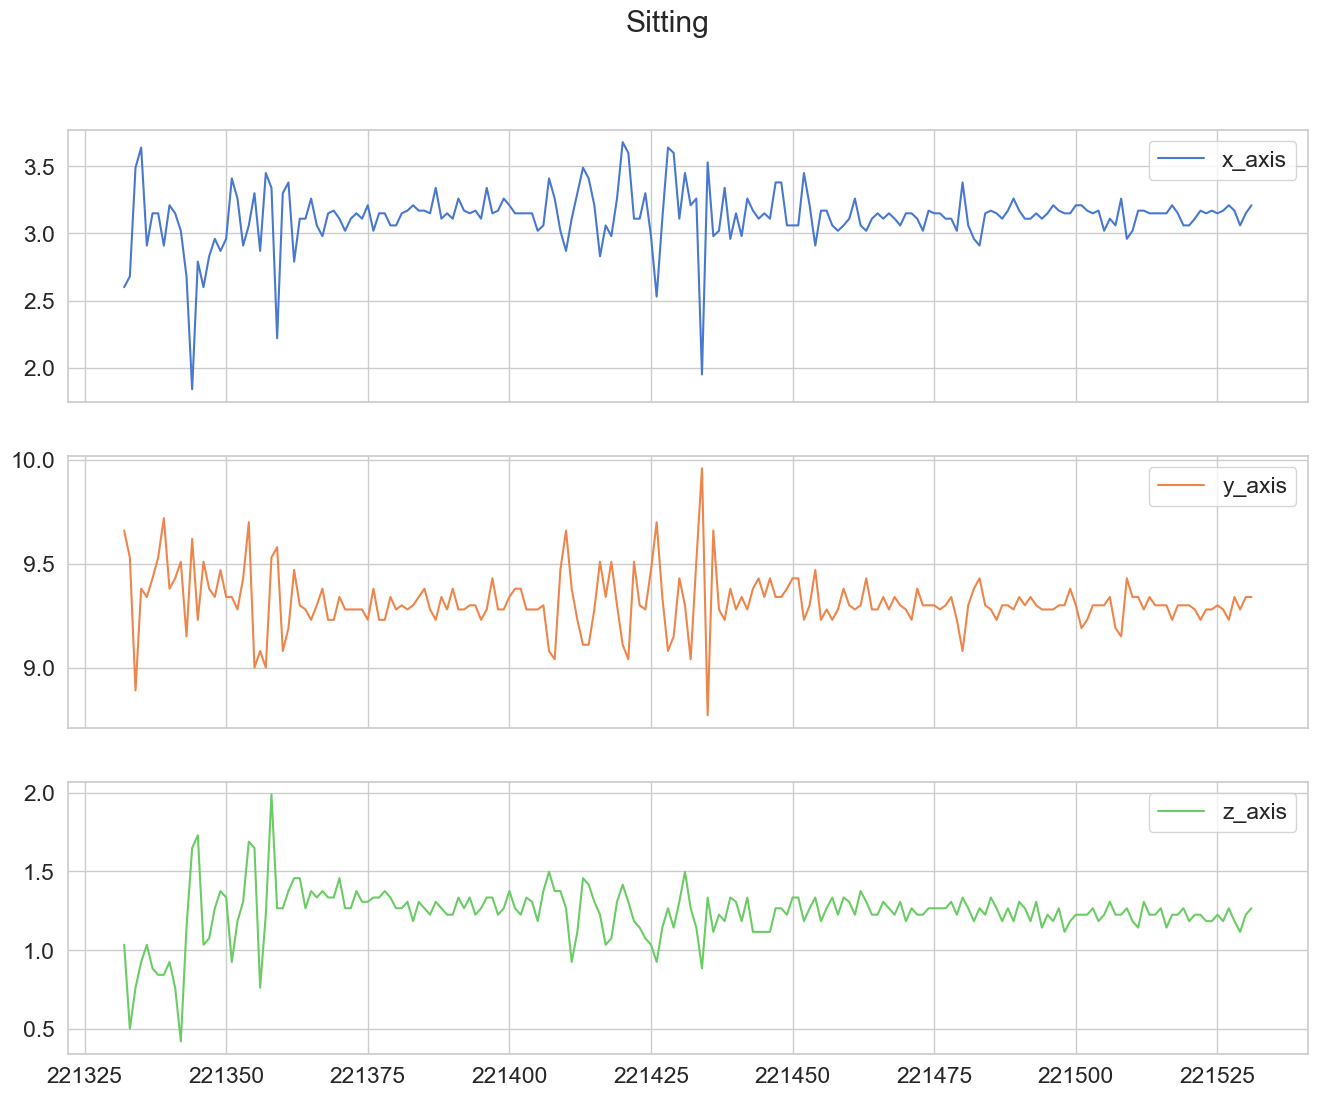

In [12]:
plot_activity('Sitting',user_data)

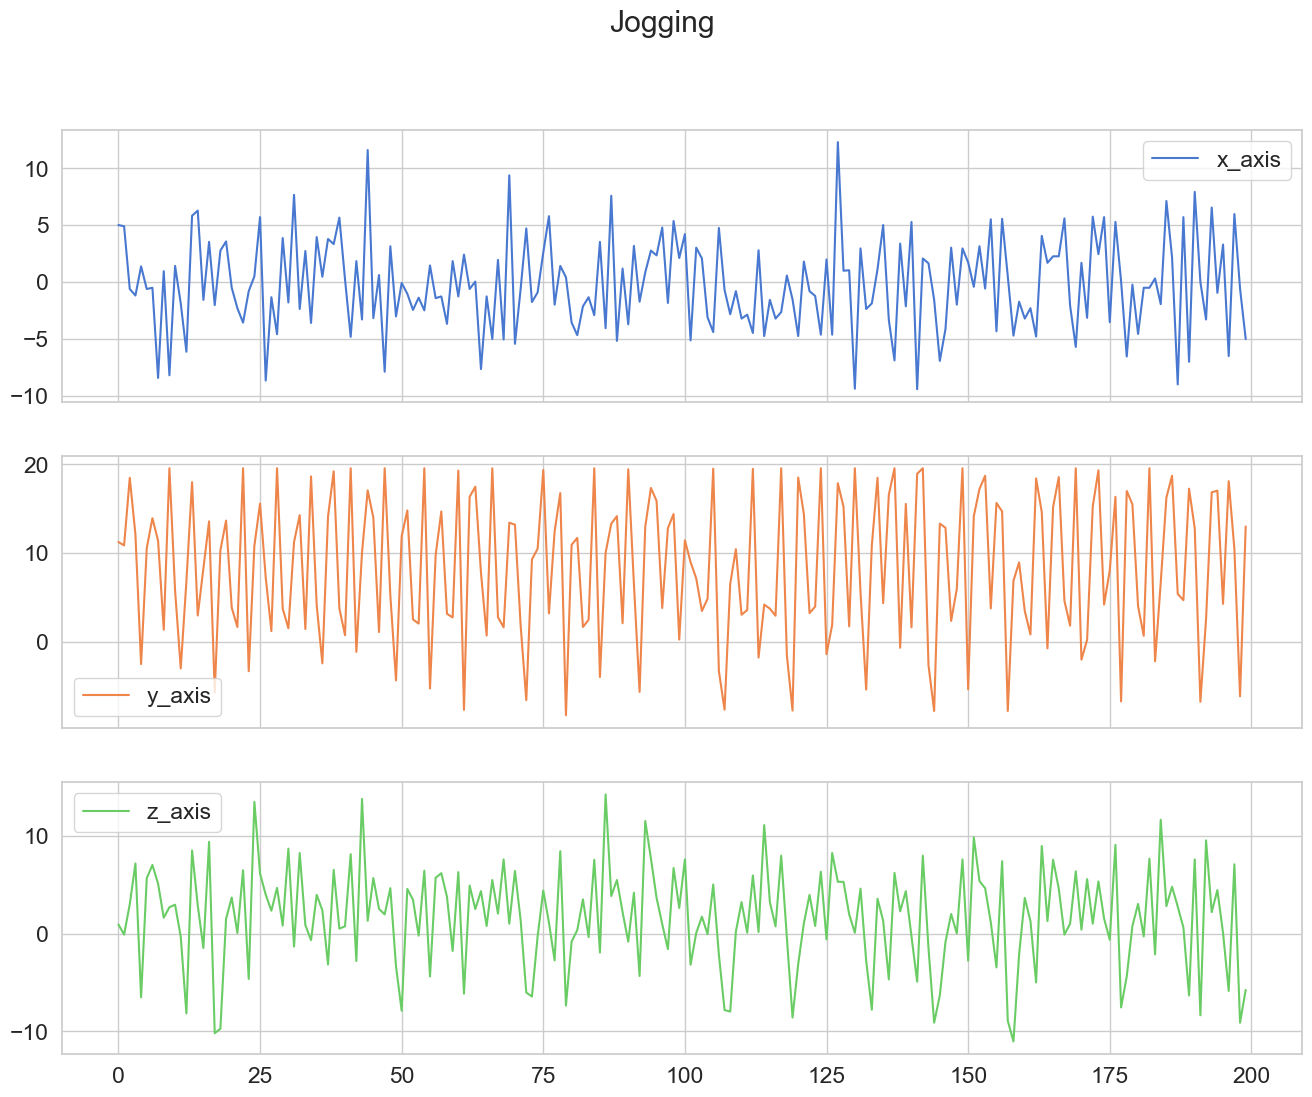

In [13]:
plot_activity('Jogging',user_data)

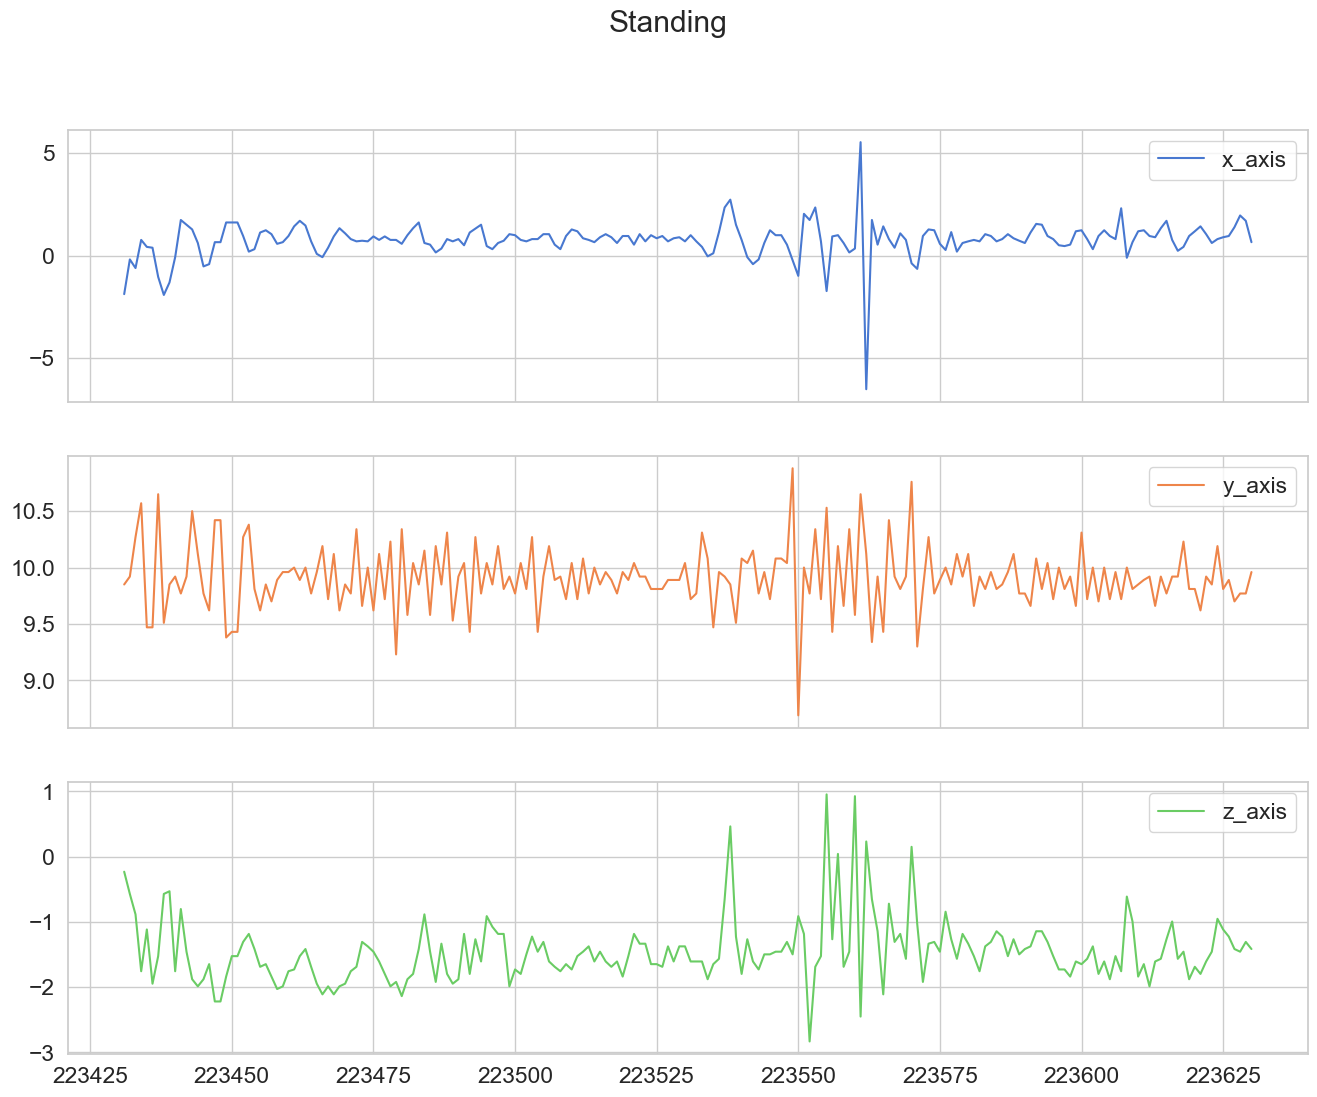

In [14]:
plot_activity('Standing',user_data)

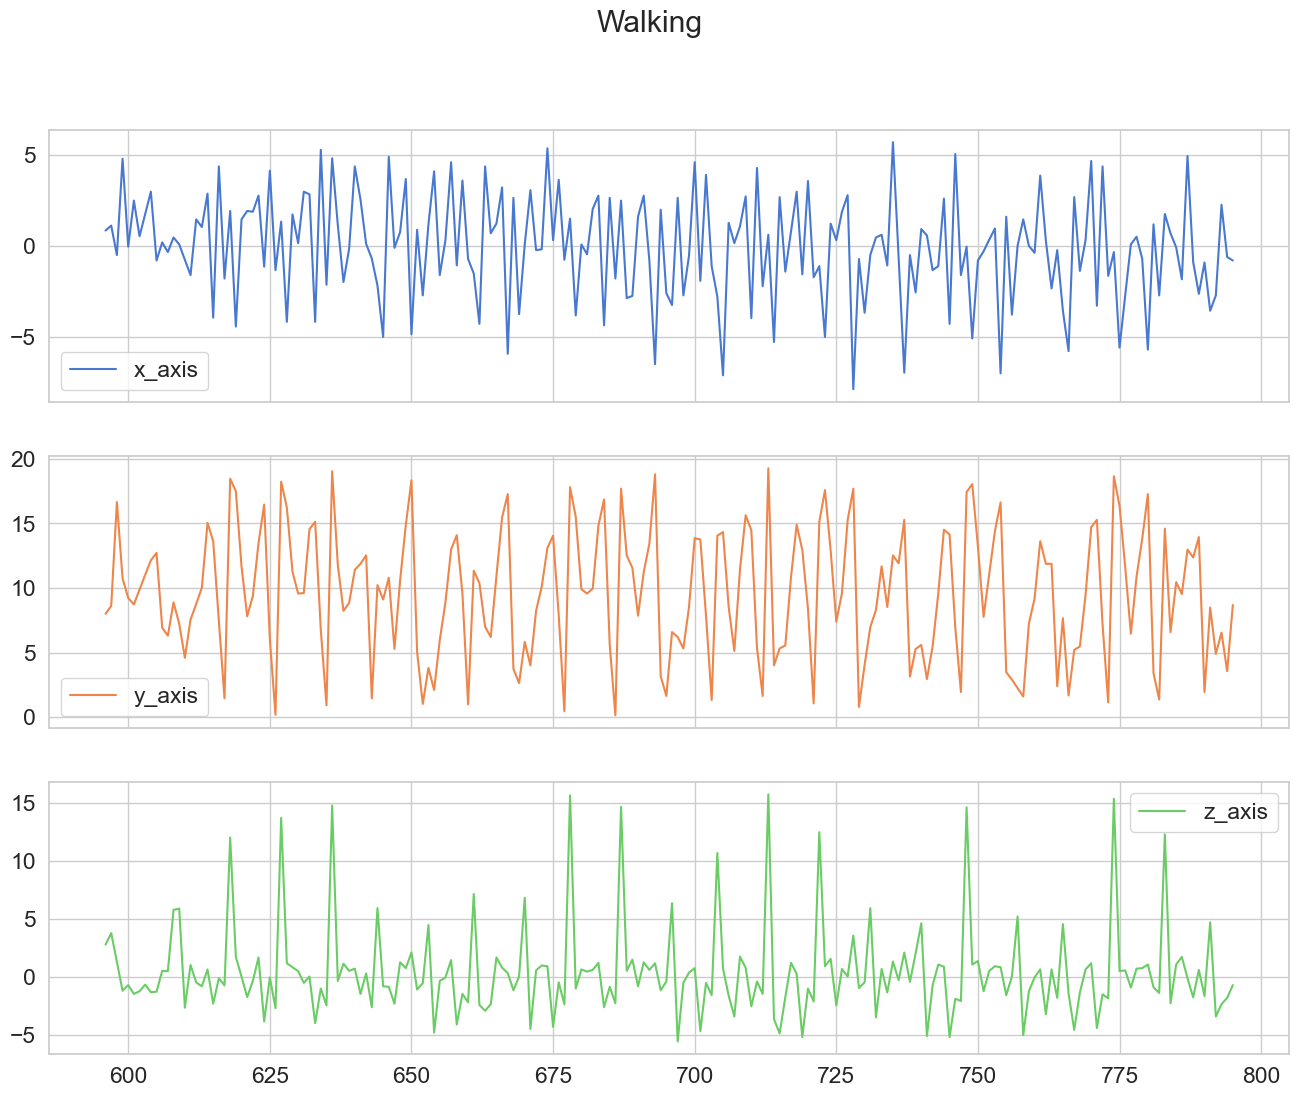

In [15]:
plot_activity('Walking',user_data)

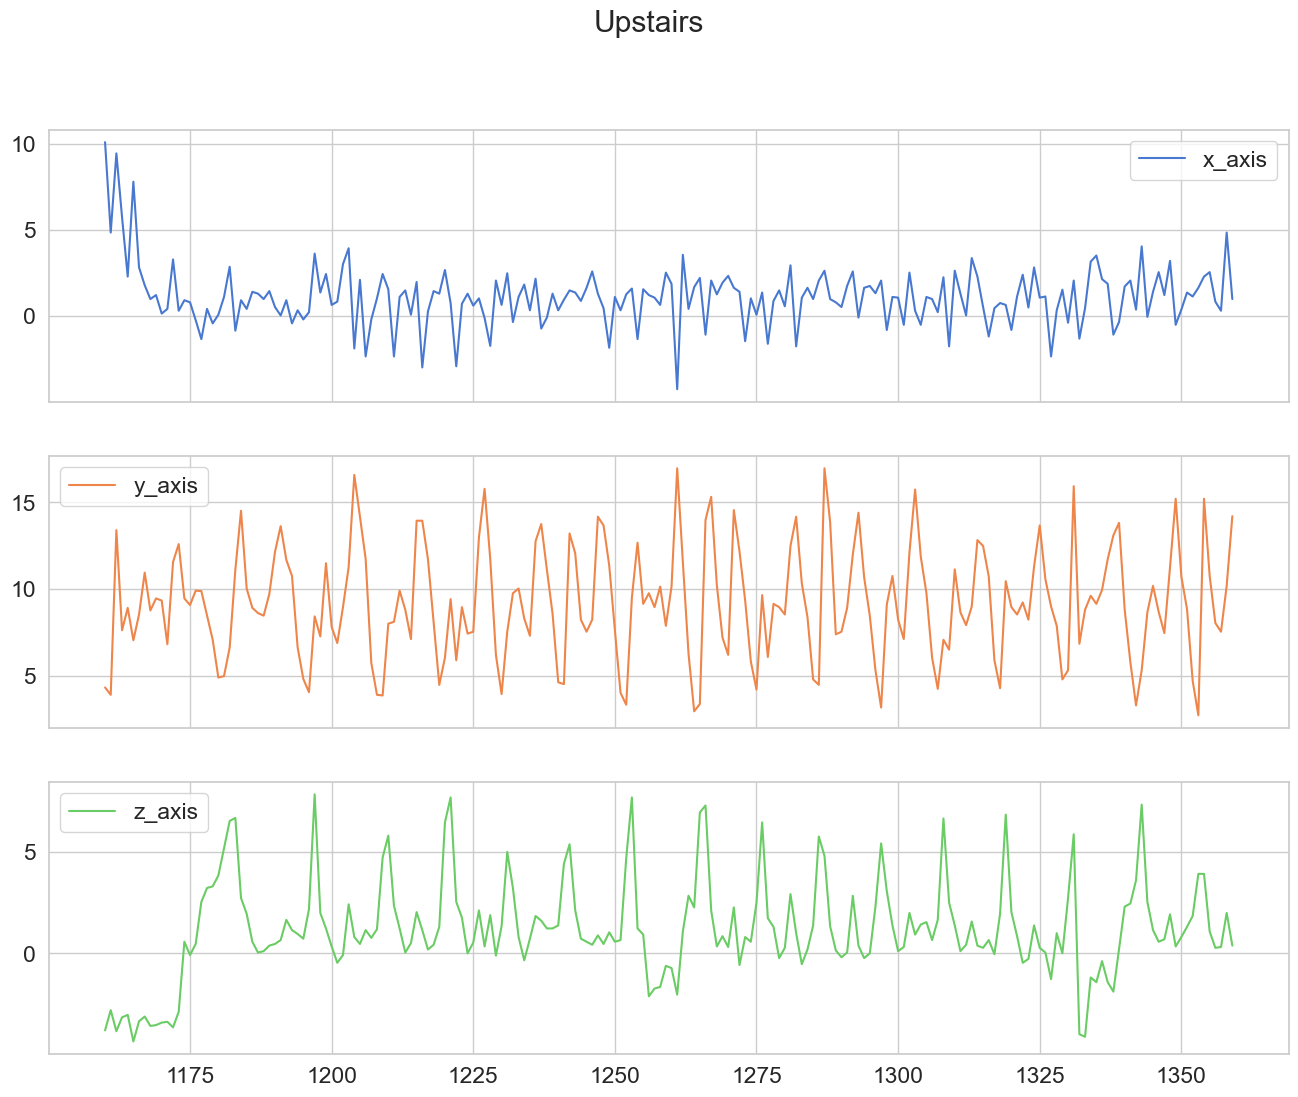

In [16]:
plot_activity('Upstairs',user_data)

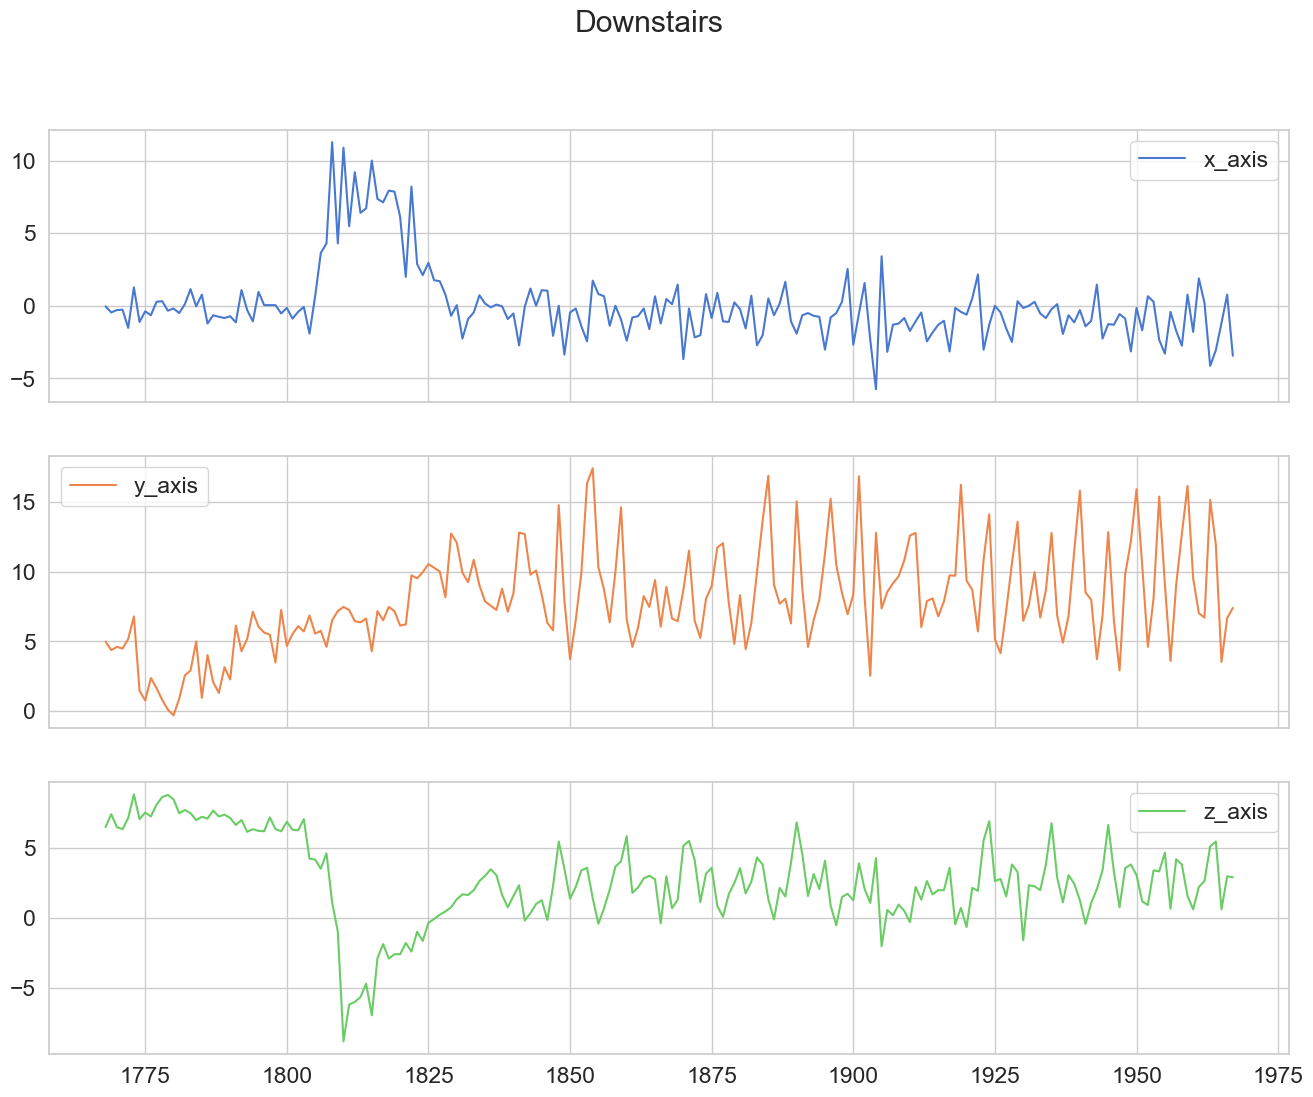

In [17]:
plot_activity('Downstairs',user_data)

## Data Preprocessing 

In [18]:
N_time_steps = 200
steps = 20 
N_features= 3
segments = []
lables = []
for i in range (0, len(user_data) - N_time_steps, steps ):
    xs = user_data['x_axis'].values[i:i + N_time_steps]
    ys = user_data['y_axis'].values[i:i + N_time_steps]
    zs = user_data['z_axis'].values[i:i + N_time_steps]
    lable = stats.mode(user_data['activity'].values[i:i + N_time_steps],keepdims=False)
#     lable = pd.DataFrame.mode(user_data['activity'].values[i:i + N_time_steps])
    lable = lable[0][0]
    segments.append([xs,ys,zs])
    lables.append(lable)

C:\Users\DIP_LAB\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
C:\Users\DIP_LAB\AppData\Local\Temp\ipykernel_10772\3330163924.py:10: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  lable = stats.mode(user_data['activity'].values[i:i + N_time_steps],keepdims=False)


In [19]:
np.array(segments).shape


(14084, 3, 200)

In [20]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_time_steps,N_features)
reshaped_segments

array([[[  5.012288  ,   4.903325  ,  -0.61291564],
        [ -1.1849703 ,   1.3756552 ,  -0.61291564],
        [ -0.50395286,  -8.430995  ,   0.95342433],
        ...,
        [ -8.349273  ,   9.575105  ,   2.2201166 ],
        [  4.4810944 ,   0.08172209,  -5.8567495 ],
        [  7.1234417 ,  -9.112013  ,  -5.7477865 ]],

       [[ -0.50395286,  -2.3018389 ,  -3.568531  ],
        [ -0.8036005 ,   0.50395286,   5.706926  ],
        [ -8.662541  ,  -1.334794  ,  -4.5900574 ],
        ...,
        [ -8.19945   ,  -1.8387469 ,   2.982856  ],
        [  3.1054392 ,   0.88532263,   8.349273  ],
        [ -2.982856  ,  15.4046135 ,   6.0882955 ]],

       [[  0.23154591,  -4.8216033 ,   1.8387469 ],
        [ -3.2961242 ,  11.604536  ,  -3.173541  ],
        [  0.61291564,  -7.8861814 ,   3.1463003 ],
        ...,
        [ -8.812365  ,   4.2904096 ,   2.2201166 ],
        [  8.349273  ,   5.7886477 ,  -9.888372  ],
        [  1.7978859 ,  -1.334794  ,   4.2086873 ]],

       ...,

      

In [21]:
reshaped_segments.shape

(14084, 200, 3)

## ONehot Encoding Lables

In [22]:
lables = np.asarray (pd.get_dummies(lables), dtype = np.float32)
#
# labels = ['a','b','c','d','e','f'] 
# s = pd.Series(np.random.randn(6),index=labels)
# print(s)


In [23]:
print(lables)
print(lables.shape)

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
(14084, 5)


## Train_Test Splitting

In [24]:
x_train, x_test, y_train, y_test =  train_test_split(reshaped_segments, lables, test_size=0.2, random_state=RANDOM_SEED)

In [25]:
len(x_train)

11267

In [26]:
len(x_test)

2817

## Creating LSTM_ Model

In [27]:
N_classes= 5
N_Units_hidden = 64

In [47]:
def create_LSTM_Model(inputs):
    w = {
        'hidden': tf.Variable(tf.random.normal([N_features, N_Units_hidden])),
        'output':tf.Variable(tf.random.normal([N_Units_hidden, N_classes]))
    }
    baises =  {
        
        'hidden': tf.Variable(tf.random.normal([N_Units_hidden], mean = 1.0)),
        'output':tf.Variable(tf.random.normal([N_classes]))    
    }
    
    x = tf.transpose(inputs, [1,0,2])
    X = tf.reshape(x, [ -1, N_features])
    
    hidden = tf.nn.relu(tf.matmul(X, w['hidden']) + baises['hidden'])
    hidden = tf.split(hidden, N_time_steps, 0) 
    # Stack 2 LSTM layers 
    lstm_layers = (tf.estimator.experimental.BasicLSTMCell(N_Units_hidden, forget_bias=1.0)for _ in range(2))#create 2 LSTM layers
#     lstm_layers = tf.estimator.experimental.MultiRNNCell(lstm_layers) #Stacks them
   
    outputs, _ =tf.compat.v1.nn.static_rnn(lstm_layers, hidden, dtype = tf.float32, state)#Actually creates a LSTM network out of LSTM layers 
     # Get output for the last time step
    lstm_last_output = outputs(-1)
        #return tf.matmul(lstm_last_output, W['output']) + biases['output']
    return tf.matmul(lstm_last_output, W['output']) + biases['output']

    
    

## Creating Placeholder

In [29]:
tf.compat.v1.disable_eager_execution()
x = tf.compat.v1.placeholder(
    dtype= tf.float32 , shape=[None, N_time_steps, N_features], name="input")

y = tf.compat.v1.placeholder(
    dtype= tf.float32 , shape=[None, N_classes])


## CReating the Model

In [48]:
pred_y = create_LSTM_Model(x)
pred_softmax = tf.nn.softmax(pred_y,  name='y_')

Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


TypeError: The argument 'cell' (<generator object create_LSTM_Model.<locals>.<genexpr> at 0x000001CE4D88FAE0>) is not an RNNCell: 'output_size' property is missing, 'state_size' property is missing, either 'zero_state' or 'get_initial_state' method is required, is not callable.